# IPAI Homework 5. SMS Spam 

#### Work done by Pavel Tishkin, p.tishkin@innpolis.university

# Prerequisites

In [ ]:
!pip install pandas
!pip install numpy
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pytorch-lightning
!pip install sklearn

## Imports

In [1]:
import re
import string
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pytorch_lightning as pl
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score

## References

1. Model and Preprocessing: https://www.kaggle.com/shresthadipak/spam-detection-lstm-vs-bi-lstm-98-accuracy
2. Plotting decision boundaries https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
3. Plotting decision boundaries: IPAI Lab 12. Single class classifier

## Loading Dataset

In [2]:
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class SpamDataset(Dataset):
    """Spam messages dataset"""
    
    def __init__(self, csv_file: str = 'SMSSpamCollection.txt'):
        """
        csv_file: str - path to csv file
        """
        df = pd.read_csv(csv_file, names=['label', 'message'], sep='\t')
        df = self.clean_dataset(df)
        self.df = df
        # Splitting the data, following the tutorial:
        
        
    def setup(self, tokenizer, split: float = 0.8):
        """
        tokenizer: Tokenizer, keras tokenizer
        split: float, must be in range (0; 1). Percentage of the original dataset used for tokenizer training
        """
        # Tokenizer - made as a parameter because the field from it is also used in a model
        assert 0.0 < split < 1, 'Split value should be in range (0; 1)'
        df_train = self.df.sample(frac=split)['message']
        tokenizer.fit_on_texts(df_train)
        self.idx_len =  len(tokenizer.word_index) + 1000
        self.embeddings = pad_sequences(tokenizer.texts_to_sequences(self.df['message']), maxlen = 50)
        self.labels = self.df['label'].tolist()
    
    def clean_dataset(self, dataset):
        """
        dataset: pd.DataFrame, dataset to be cleaned
        """
        # Using celaning techniques from the original work
        dataset.drop_duplicates().reset_index(drop=True)
        dataset = dataset.replace('ham', 0)
        dataset = dataset.replace('spam', 1)
        dataset['message'] = dataset['message'].apply(lambda x: self.clean_text(x))
        return dataset
    
    def clean_text(self, text):
        """
        text: str, text string to be preprocessed
        """
        # Using cleaning techniques from the original work
        text = text.lower()
        text = re.sub('\[.*?\]', '', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\w*\d\w*', '', text)
        return text
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return (torch.tensor(self.embeddings[idx]), self.labels[idx])
        

## Lightning Data Module

In [3]:
class SpamDataModule(pl.LightningDataModule):
    def __init__(self,  tokenizer, data_dir: str = "SMSSpamCollection.txt", batch_size: int = 32, train_size: float = 0.9, test_size: float = 0.05):
        """
        tokenizer: Tokenizer, keras tokenizer
        data_dir: string, directory of csv file
        batch_size: int, size of the batch
        train_size: float, percentage of the train dataset size
        test_size: float, percentage of the test dataset size
        """
        # Pytorch lightning requires train, test, validation sets...
        # So train size will be 0.9, validation - 0.09
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_size = train_size
        self.test_size = test_size
        self.tokenizer = tokenizer

    def setup(self, stage=None):
        data_full = SpamDataset()
        data_full.setup(self.tokenizer)
        train_size = int(len(data_full)*self.train_size)
        test_size = int(len(data_full)*self.test_size)
        val_size = len(data_full) - train_size - test_size
        self.spam_train, test_val = random_split(data_full, [train_size, test_size + val_size])
        self.spam_test, self.spam_val = random_split(test_val, [test_size, val_size])
    
    def train_dataloader(self):
        return DataLoader(self.spam_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.spam_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.spam_test, batch_size=self.batch_size)

## Ligtning Model

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Following the tutorial from https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html

class SpamModel(pl.LightningModule):
    def __init__(self, vocab_size: int):
        """
        vocab_size: int, size of the vocabulary in tokenizer
        """
        # model based on the model from work https://www.kaggle.com/shresthadipak/spam-detection-lstm-vs-bi-lstm-98-accuracy
        super().__init__()
        # Parameters from the original work
        n_lstm = 200
        drop_lstm =0.2
        embedding_dim = 16    
        # Binary cross entropy
        self.loss = nn.BCELoss()
        self.emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim,)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=n_lstm, num_layers=2, dropout=drop_lstm, batch_first=True)
        self.lin = nn.Linear(n_lstm, 1)
        # Turns out using ReLU there makes zero to none updates in the loss function
#         self.relu = nn.ReLU()
        # Sigmoid has to be applied for correct working of the BCELoss. Moreover, it is better for learning
        self.out = nn.Sigmoid()
        
    def forward(self, x):
        x = self.emb(x)
        # We do not need lstm hidden states for our model
        x, (h, _) = self.lstm(x)
        x = self.lin(h[-1])
#         x = self.relu(x)
        return self.out(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        # Prediction returns a vector of size [batch_size, 50, 1], so we need to take the last
        # prediction from lstm, as it returns predictions for all sequence
        pred = self(x)
        # Calculating loss
        loss = self.loss(pred.flatten(), y.to(torch.float32))
        # The sceleton of the code was partially used and reworked from the
        # Assignment 1 of PMLDL course of Innopolis university
        # This particular line was used when there was not enough memory on my PC
        torch.cuda.empty_cache()
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = self.loss(pred.flatten(), y.to(torch.float32))
        torch.cuda.empty_cache()
        # Calculating accuracy. The threshold of message being a spam
        # Is getting p>0.5
        acc = accuracy_score(y, pred>0.5)
        return {'loss': loss, 'accuracy': acc}
    
    def validation_epoch_end(self, outputs):
        # Logging accuracy
        avg_accuracy = np.array([x['accuracy'] for x in outputs]).mean()
        self.logger.experiment.add_scalar("Accuracy/Val", avg_accuracy, self.current_epoch)
    
    def training_epoch_end(self, outputs):
        # logging losses
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.logger.experiment.add_scalar("Loss/Train", avg_loss, self.current_epoch)

    def configure_optimizers(self):
        # Optimizers. Adam was used as it was in the original work
        return torch.optim.Adam(self.parameters(), lr=0.1)

In [11]:
tokenizer = Tokenizer()
train_loader = SpamDataModule(tokenizer)
train_loader.setup()
logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="my_model")
trainer = pl.Trainer(max_epochs=10, logger=logger)
model = SpamModel(len(tokenizer.word_index) + 1000)

trainer.fit(model, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type      | Params
-----------------------------------
0 | loss | BCELoss   | 0     
1 | emb  | Embedding | 134 K 
2 | lstm | LSTM      | 496 K 
3 | lin  | Linear    | 201   
4 | out  | Sigmoid   | 0     
-----------------------------------
630 K     Trainable params
0         Non-trainable params
630 K     Total params
2.521     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

c:\users\pavel\appdata\local\programs\python\python38\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Tensorboard with the graphs from the training. 

In order to open it, place the notebok and the log files in the same folder, then run the cell below in jupyter. If does not work, maybe you need to install tensorboard: 
```cmd
!pip install tensorboard
```

Be aware, there should be only a single version of tensorboard on your system!

In [12]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/ --port=8921

As we can observe from the graphs on tensoroard, there is no point in training model furhter after the fifth epoch. Accuracy of the model on the training set is approximately 0.86. It appears the model suffers from overfitting, so the training epochs could be decreased. Enormous loss functions were because of lack of Sigmoid Activation in the end, which is required by PyTorch loss function

# Visualizing decision boundaries 

## Evaluating model on the whole dataset

In [13]:
# Reworked from teh HW1 of PMLDL Course
model.eval()

spam_data = SpamDataset()
spam_data.setup(tokenizer)

spam_data_loader = DataLoader(spam_data, batch_size=64)

spam_labels, spam_embeddings, spam_predictions = [], [], []

with torch.no_grad():
    for idx, data in enumerate(spam_data_loader):
        
        texts, labels = data

        spam_labels.extend(list(map(lambda x: x.item(), labels)))
        spam_embeddings.extend(texts.numpy())
        spam_predictions.extend(model(texts).numpy())

        if idx % 10  == 0:
            print(f"{idx}/{len(spam_data_loader)}")

0/88
10/88
20/88
30/88
40/88
50/88
60/88
70/88
80/88


In [16]:
# Postprocessing labels and embeddings
spam_predictions = [s.item() > 0.5 for s in spam_predictions]
spam_embeddings = np.array(spam_embeddings)

In [17]:
print(f'Accuracy of the model: {accuracy_score(spam_labels, spam_predictions)}')

Accuracy of the model: 0.8365039483129936


## Plotting boundaries

Trying to use tsne from the Lab

In [18]:
# Used from the lab on Introduction to Practical Artificial Intelligence cource

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

## credits go to https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
def show_tsne(X, y):
    tsne = TSNE(n_components=2, random_state=1)
    tsne_results = tsne.fit_transform(X)
    data = {}
    data['tsne-2d-one'] = tsne_results[:,0]
    data['tsne-2d-two'] = tsne_results[:,1]
    data['class'] = y
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        style="class", hue="class",
        data=data,
        legend="full",
        alpha=0.7
    )

In [ ]:
show_tsne(spam_embeddings, spam_predictions)

In [17]:
from sklearn.decomposition import PCA

def show_PCA(X, y):
    # Credits go to the code above. The only change is PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(X)
    data = {}
    data['pca-2d-one'] = pca_results[:,0]
    data['pca-2d-two'] = pca_results[:,1]
    data['class'] = y
    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="pca-2d-one", y="pca-2d-two",
        style="class", hue="class",
        data=data,
        legend="full",
        alpha=0.7
    )

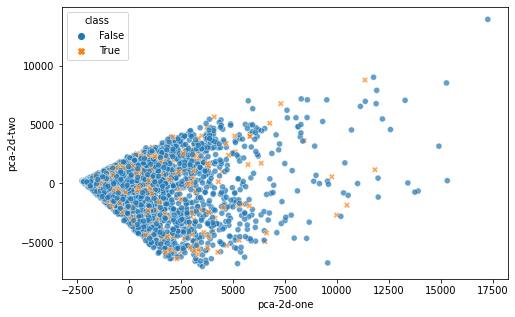

In [18]:
show_PCA(spam_embeddings, spam_predictions)

In [19]:
def show_PCA_3d(X, y):
    # Credits go to the code above and to https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
    pca = PCA(n_components=3)
    pca_results = pca.fit_transform(X)
    data = {}
    data['pca-3d-one'] = pca_results[:,0]
    data['pca-3d-two'] = pca_results[:,1]
    data['pca-3d-three'] = pca_results[:,2]
    data['class'] = y
    ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.scatter(
        xs=data["pca-3d-one"], 
        ys=data["pca-3d-two"], 
        zs=data["pca-3d-three"], 
        c=data["class"], 
        cmap='tab10'
    )
    ax.set_xlabel('pca-3d-one')
    ax.set_ylabel('pca-3d-two')
    ax.set_zlabel('pca-3d-three')
    plt.show()

<ipython-input-19-1170ff8ae8aa>:10: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16,10)).gca(projection='3d')


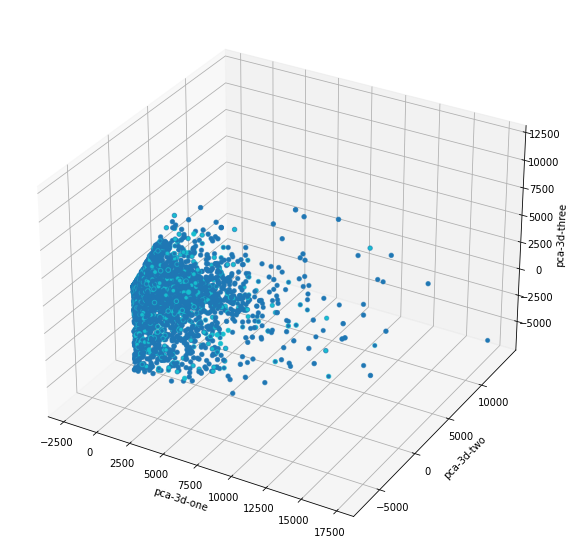

In [20]:
show_PCA_3d(spam_embeddings, spam_predictions)

It is probably not an interpretable result, because we have 50 dimensions in the original dataset...